In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle

import sys, os
from tqdm import tqdm
from copy import deepcopy
sys.path.append(os.path.join(os.getcwd().split("PCNN")[0], "PCNN/src/"))
from game.constants import *
import core.build.pclib as pclib
import libs.pclib2 as pclib2
import utils
from game.envs import *
import game.objects as objects
import simulations as sim
#import analysis.study_density as sd

logger = utils.setup_logger('An.DNS', level=3)


#import pcnn_core as pcr
from IPython.display import clear_output
from tqdm import tqdm
import time, json, os

%load_ext autoreload
%autoreload 2

logger = utils.setup_logger("M", level=1)
logger()

M | 2025-05-25 22:37:57 | 


In [126]:
MPATH = "../media/plots"

## study remapping

**General parameters**

In [43]:
1.*0.015, 0.05 * 0.015, 1.*0.006, 0.05*0.006, 0.01*0.015

(0.015, 0.00075, 0.006, 0.00030000000000000003, 0.00015)

In [8]:
reward_settings = {
    "rw_fetching": "probabilistic",
    "rw_value": "discrete",
    "rw_position": np.array([0.5, 0.3]) * GAME_SCALE,
    "rw_radius": 0.1 * GAME_SCALE,
    "rw_sigma": 1.5 * GAME_SCALE,
    "rw_bounds": np.array([0.23, 0.77,
                           0.23, 0.77]) * GAME_SCALE,
    "delay": 150,
    "silent_duration": 5_000,
    "fetching_duration": 1,
    "transparent": False,
    "beta": 30.,
    "alpha": 0.06,
}

agent_settings = {
    # "speed": 0.7,
    "init_position": np.array([0.2, 0.2]) * GAME_SCALE,
    "agent_bounds": np.array([0.23, 0.77,
                              0.23, 0.77]) * GAME_SCALE,
}

game_settings = {
    "plot_interval": 5,
    "rw_event": "move agent",
    "rendering": False,
    "rendering_pcnn": False,
    "max_duration": 8_000,
    "room_thickness": 30,
    "seed": None,
    "pause": -1,
    "verbose": False
}

global_parameters = {
    "local_scale_fine": 0.015,
    "local_scale_coarse": 0.006,
    "N": 30**2,
    "rec_threshold_fine": 24.,
    "rec_threshold_coarse": 70.,
    "speed": 1.5,
    "min_weight_value": 0.6
}

""" Model parameters """
PARAMETERS = {

    "gain_fine": 11.,
    "offset_fine": 1.2,
    "threshold_fine": 0.4,
    "rep_threshold_fine": 0.9,

    "gain_coarse": 11.,
    "offset_coarse": 1.2,
    "threshold_coarse": 0.4,
    "rep_threshold_coarse": 0.89,

    "lr_da": 0.4,
    "threshold_da": 0.08,
    "tau_v_da": 1.0,

    "lr_bnd": 0.4,
    "threshold_bnd": 0.04,
    "tau_v_bnd": 1.0,

    "tau_ssry": 100.,
    "threshold_ssry": 0.95,

    "threshold_circuit": 0.7,

    "rwd_weight": 0.0,
    "rwd_sigma": 40.0,
    "col_weight": 0.0,
    "col_sigma": 30.0,

    "action_delay": 15.,
    "edge_route_interval": 80,

    "forced_duration": 100,
    "fine_tuning_min_duration": 15
}


In [5]:
reward_settings = {
    "rw_fetching": "deterministic",
    "rw_value": "discrete",
    "rw_position": np.array([0.5, 0.3]) * GAME_SCALE,
    "rw_radius": 0.05 * GAME_SCALE,
    "rw_sigma": 0.8,# * GAME_SCALE,
    "rw_bounds": np.array([0.23, 0.77,
                           0.23, 0.77]) * GAME_SCALE,
    "delay": 2,
    "silent_duration": 1_000,
    "fetching_duration": 2,
    "transparent": False,
    "beta": 40.,
    "alpha": 0.06,# * GAME_SCALE,
    "move_threshold": 4,# * GAME_SCALE,
    "rw_position_idx": 0,
}

game_settings = {
    "plot_interval": 5,
    "rw_event": "move agent",
    "rendering": True,
    "agent_bounds": np.array([0.23, 0.77,
                              0.23, 0.77]) * GAME_SCALE,
    "max_duration": 50_000,
    "room_thickness": 30,
    "t_teleport": 3_000,
    "limit_position_len": -1,
    "start_position_idx": 1,
    "seed": None,
    "pause": -1,
    "verbose": True
}

global_parameters = {
    "local_scale": 0.015,
    "N": 32**2,
    "use_sprites": bool(0),
    "speed": 1.0,
    "min_weight_value": 0.5
}


PARAMETERS = {
      "gain": 102.4,
      "offset": 1.02,
      "threshold": 0.4,
      "rep_threshold": 0.999,
      "rec_threshold": 33,
      "tau_trace": 10,
      "remap_tag_frequency": 1,
      "num_neighbors": 4,
      "min_rep_threshold": 0.99,
      "lr_da": 0.9,
      "lr_pred": 0.05,
      "threshold_da": 0.05,
      "tau_v_da": 1.0,
      "lr_bnd": 0.9,
      "threshold_bnd": 0.1,
      "tau_v_bnd": 1.0,
      "tau_ssry": 437.0,
      "threshold_ssry": 1.986,
      "threshold_circuit": 0.9,
      "rwd_weight": -2.11,
      "rwd_sigma": 96.8,
      "rwd_threshold": 0.49,
      "col_weight": -0.53,
      "col_sigma": 16.1,
      "col_threshold": 0.37,
      "rwd_field_mod": 4.6,
      "col_field_mod": 4.4,
      "action_delay": 120.0,
      "edge_route_interval": 50,
      "forced_duration": 19,
      "min_weight_value": 0.1,
    "modulation_options": [True]*4
}



#### run

In [4]:
params = PARAMETERS.copy()
params["rwd_weight"] = 0.1


PARAMETERS

NameError: name 'PARAMETERS' is not defined

In [6]:
tot = 6
values = np.concatenate((np.around(np.linspace(-0.5, 0., tot//2, endpoint=False), 2),
                         np.around(np.linspace(0, 0.5, tot//2, endpoint=False), 2),
                        np.array([0.5])))
logger(f"{values=}")

M | 2025-05-25 22:39:03 | values=array([-0.5 , -0.33, -0.17,  0.  ,  0.17,  0.33,  0.5 ])


In [17]:
tot = 6
reps = 4
values = np.concatenate((np.around(np.linspace(-0.5, 0., tot//2, endpoint=False), 2),
                         np.around(np.linspace(0, 0.5, tot//2, endpoint=False), 2),
                        np.array([0.5])))
logger(f"{values=}")
tot = len(values)
res = np.zeros((tot, tot))

for i in range(tot):
    logger(f"{i=} | {values[i]}")
    for j in tqdm(range(tot)):
        params = PARAMETERS.copy()
        params["rwd_weight"] = values[i]
        params["col_weight"] = values[j]
        
        result = sim.run_model(
                    parameters=params,
                    global_parameters=global_parameters,
                    agent_settings=agent_settings,2


                    reward_settings=reward_settings,
                    game_settings=game_settings,
                    room_name="Square.v0",
                    verbose=False,
                    verbose_min=False)
        res[i, j] = result

logger("[terminated]")

2025-02-14 16:07:17 | values=array([-0.5 , -0.33, -0.17,  0.  ,  0.17,  0.33,  0.5 ])
2025-02-14 16:07:17 | i=0 | -0.5
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 20.17s/it]
2025-02-14 16:09:38 | i=1 | -0.33
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:11<00:00, 18.80s/it]
2025-02-14 16:11:50 | i=2 | -0.17
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

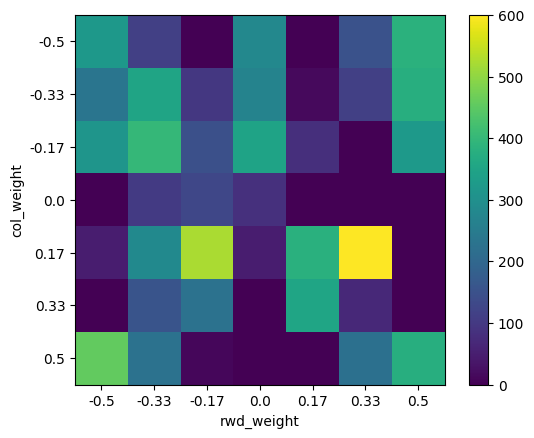

In [35]:
#res1 = res.copy()
plt.imshow(res1, cmap="viridis")
plt.xticks(range(tot), values)
plt.yticks(range(tot), values)
plt.xlabel(r"rwd_weight")
plt.ylabel(r"col_weight")
plt.colorbar()
plt.show()

## Plotting

In [75]:
f.endswith("json")

False

In [82]:
respath = "../src/analysis/results"
files = os.listdir(respath)
for i, f in enumerate(files):
    if f.endswith("json"): continue
    print(f"{i} {f}")

0 remap_142_229
3 remap_152_1615
5 remap_152_237
6 remap_152_1523


In [83]:
idx = 3

with open(f"{respath}/{files[idx]}/data.json", "r") as f:
    data = json.load(f)
with open(f"{respath}/{files[idx]}/values.json", "r") as f:
    values = json.load(f)

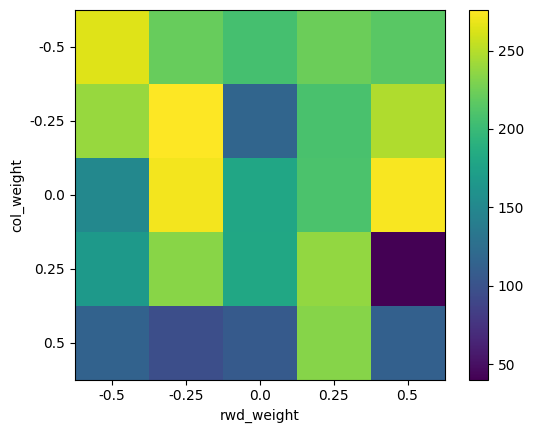

In [84]:
#res1 = res.copy()
plt.imshow(data, cmap="viridis")
plt.xticks(range(len(values)), values)
plt.yticks(range(len(values)), values)
plt.xlabel(r"rwd_weight")
plt.ylabel(r"col_weight")
plt.colorbar()
plt.show()

## study II

In [10]:
def calc_density_values(graph: np.ndarray, rw_position: np.ndarray,
                        rw_radius: float, area_radius: float,
                        env_length: float) -> tuple:

    """
    calculation of the average density around the reward location in
    an area of radius #area_radius (but not within the reward radius)
    and outside.

    Parameters
    ----------
    graph: np.ndarray
        node centers, as a (N, 2) array
    rw_position: np.ndarray
        reward position
    rw_radius: float
    area_radius: float
    env_length: float

    Returns
    -------
    tuple: (float, float)
        density near, density far
    """

    rx, ry = rw_position
    num_near = 0
    num_far = 0

    # calculate counts
    for c in graph:
        dist = np.sqrt((c[0]-rx)**2 + (c[1]-ry)**2)
        if dist < area_radius:
            num_near += 1
        else:
            num_far += 1

    # calculate areas
    area_near = 2 * np.pi * (area_radius - rw_radius)
    area_far = env_length ** 2

    # densities
    return num_near / area_near, num_far / area_far


def compute_place_field(positions, activations, grid_size=20,
                        method='max', threshold=0.1):
    """
    Create a 2D place field map by binning the space and aggregating neuron activation.

    Args:
        positions: (T, 2) positions (x, y) over time
        activations: (T,) activation of the neuron over time
        grid_size: int, spatial resolution
        method: 'max' or 'mean'

    Returns:
        field: (grid_size, grid_size) 2D place field
    """
    field = np.zeros((grid_size, grid_size))
    counts = np.zeros_like(field)

    # Normalize positions to [0, 1]
    pos_min = positions.min(axis=0)
    pos_max = positions.max(axis=0)
    norm_positions = (positions - pos_min) / (pos_max - pos_min + 1e-8)

    # Compute bin indices
    bins = np.floor(norm_positions * grid_size).astype(int)
    bins = np.clip(bins, 0, grid_size - 1)

    for t in range(len(activations)):
        x, y = bins[t]
        if method == 'max':
            field[y, x] = max(field[y, x], activations[t])
            field[y, x] = field[y, x] if field[y, x] > threshold else 0.
        elif method == 'mean':
            field[y, x] += activations[t]
            counts[y, x] += 1

    if method == 'mean':
        field = np.divide(field, counts, where=counts > 0)

    return field

def _make_pc_fields(brain: object):

    gc = brain.get_gc_network()
    wff = brain.get_wff()
    logger(gc)

    # random walk
    speed = 0.9
    size = 200.
    lims = (-250, 250)

    points = [[0., 0.]]

    s = np.array([speed, speed])
    x, y = points[0]
    old_point = points[0]

    tot = 200_000

    # record
    activity = np.zeros((len(gc), tot))
    plotting = False

    for t in tqdm(range(tot)):

        x += s[0]
        y += s[1]

        # hit wall
        if x <= lims[0] or x >= lims[1]:
            s[0] *= -1
            x += s[0]
        elif y <= lims[0] or y >= lims[1]:
            s[1] *= -1
            y += s[1]

        points += [[x, y]]
        if t % 1000 == 0:
            s = np.random.uniform(-1, 1, 2)
            s = speed * s / np.abs(s).sum()
            s = np.around(s, 3)

        activity[:, t] = gc([points[-1][0]-old_point[0],
                             points[-1][1]-old_point[1]])

        old_point = points[-1]

        if t % 100 == 0 and plotting:
            clear_output(wait=True)
            plt.figure(figsize=(4, 4))
            #plt.subplot(121)
            plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)

            plt.title(f"{t=}")
            plt.scatter(*points[-1], s=100, c='r')

            plt.xlim((-4, size+4))
            plt.ylim((-4, size+4))
            plt.pause(0.001)

    logger("[trajectory done]")

    pc = []
    trajectory = np.array(points)
    activity_pc = wff @ activity
    for i in tqdm(range(len(activity_pc))):
        pc += [compute_place_field(trajectory[1:],
                                   activity_pc[i],
                                   grid_size=500,
                                   threshold=1.)]
    pc = np.stack(pc)
    cc = brain.get_space_centers()
    cc = cc[np.where(cc[:, 0]>-2000)[0]]

    return pc, cc

RANDOM_SEQUENCE = np.random.uniform(-1, 1, (100_000, 2))

def make_pc_field_v2(space):

    space.reset()

    # random walk
    speed = 0.8
    lims = (-350, 350)
    
    points = [[0., 0.]]
    
    s = np.array([speed, speed])
    x, y = points[0]
    old_point = points[0]
    
    tot = 200_000
    
    # record
    activity = np.zeros((space.get_size(), tot))
    plotting = False
    
    for t in tqdm(range(tot)):
        
        x += s[0]
        y += s[1]
    
        # hit wall
        if x <= lims[0] or x >= lims[1]:
            s[0] *= -1
            x += s[0]
        elif y <= lims[0] or y >= lims[1]:
            s[1] *= -1
            y += s[1]
    
        points += [[x, y]]
        if t % 1000 == 0:
            #s = np.random.uniform(-1, 1, 2)
            s = RANDOM_SEQUENCE[t//1000]
            s = speed * s / np.abs(s).sum()
            s = np.around(s, 3)
    
        activity[:, t], _ = space([points[-1][0]-old_point[0],
                                   points[-1][1]-old_point[1]])
        
        
        old_point = points[-1]
    
    logger("[trajectory done]")
    return activity.copy(), np.array(points).T.copy()


In [16]:
""" SETTINGS """

reward_settings = {
    "rw_fetching": "deterministic",
    "rw_value": "discrete",
    "rw_position": np.array([0.5, 0.3]) * GAME_SCALE,
    "rw_radius": 0.08 * GAME_SCALE,
    "rw_sigma": 0.7,# * GAME_SCALE,
    "rw_bounds": np.array([0.23, 0.77,
                           0.23, 0.77]) * GAME_SCALE,
    "delay": 5,
    "silent_duration": 20_000,
    "fetching_duration": 4,
    "transparent": False,
    "beta": 40.,
    "alpha": 0.06,# * GAME_SCALE,
    "tau": 200,# * GAME_SCALE,
    "move_threshold": 2005,# * GAME_SCALE,
}

game_settings = {
    "plot_interval": 5,
    "rw_event": "move both",
    "rendering": False,
    "rendering_pcnn": False,
    "agent_bounds": np.array([0.23, 0.77,
                              0.23, 0.77]) * GAME_SCALE,
    "max_duration": 40_000,
    "room_thickness": 20,
    "t_teleport": 1_500,
    "limit_position_len": -1,
    "start_position_idx": 0,
    "seed": None,
    "pause": -1,
    "verbose": True
}

global_parameters = {
    "local_scale": 0.02,
    "N": 32**2,
    "use_sprites": False,
    "speed": 1.,
    "min_weight_value": 0.5
}

parameters = {
         "gain": 102.4,
      "offset": 1.02,
      "threshold": 0.4,
      "rep_threshold": 0.999,
      "rec_threshold": 33,
      "tau_trace": 10,
      "remap_tag_frequency": 1,
      "num_neighbors": 4,
      "min_rep_threshold": 0.99,
      "lr_da": 0.9,
      "lr_pred": 0.05,
      "threshold_da": 0.05,
      "tau_v_da": 1.0,
      "lr_bnd": 0.9,
      "threshold_bnd": 0.1,
      "tau_v_bnd": 1.0,
      "tau_ssry": 437.0,
      "threshold_ssry": 1.986,
      "threshold_circuit": 0.9,
      "rwd_weight": -2.11,
      "rwd_sigma": 96.8,
      "rwd_threshold": 0.49,
      "col_weight": -0.53,
      "col_sigma": 16.1,
      "col_threshold": 0.37,
      "rwd_field_mod": 4.6,
      "col_field_mod": 4.4,
      "action_delay": 120.0,
      "edge_route_interval": 50,
      "forced_duration": 19,
      "min_weight_value": 0.1,
    "modulation_options": [True]*4

}


In [17]:
brain = pclib2.Brain(
                local_scale=global_parameters["local_scale"],
                N=global_parameters["N"],
                rec_threshold=parameters["rec_threshold"],
                speed=global_parameters["speed"],
                min_rep_threshold=parameters["min_rep_threshold"],
                gain=parameters["gain"],
                offset=parameters["offset"],
                threshold=parameters["threshold"],
                rep_threshold=parameters["rep_threshold"],
                tau_trace=parameters["tau_trace"],
                remap_tag_frequency=parameters["remap_tag_frequency"],
                lr_da=parameters["lr_da"],
                lr_pred=parameters["lr_pred"],
                threshold_da=parameters["threshold_da"],
                tau_v_da=parameters["tau_v_da"],
                lr_bnd=parameters["lr_bnd"],
                threshold_bnd=parameters["threshold_bnd"],
                tau_v_bnd=parameters["tau_v_bnd"],
                tau_ssry=parameters["tau_ssry"],
                threshold_ssry=parameters["threshold_ssry"],
                threshold_circuit=parameters["threshold_circuit"],
                rwd_weight=parameters["rwd_weight"],
                rwd_sigma=parameters["rwd_sigma"],
                rwd_threshold=parameters["rwd_threshold"],
                col_weight=parameters["col_weight"],
                col_sigma=parameters["col_sigma"],
                col_threshold=parameters["col_threshold"],
                rwd_field_mod=parameters["rwd_field_mod"],
                col_field_mod=parameters["col_field_mod"],
                action_delay=parameters["action_delay"],
                edge_route_interval=parameters["edge_route_interval"],
                forced_duration=parameters["forced_duration"],
                min_weight_value=parameters["min_weight_value"])



""" make game environment """

verbose = False
verbose_min = True
game_settings["rendering"] = False
reward_settings["silent_duration"] = 30_000
game_settings["max_duration"] = 60_000
game_settings["rw_event"] = "move agent"
t_teleport = game_settings["t_teleport"]

room_name = "Square.v0"

if verbose and verbose_min:
    logger(f"room_name={room_name}")

room = make_room(name=room_name,
                 thickness=game_settings["room_thickness"],
                 bounds=[0, 1, 0, 1])
room.set_room_positions([[450, 450]])
room_bounds = [room.bounds[0]+10, room.bounds[2]-10,
               room.bounds[1]+10, room.bounds[3]-10]

logger()

M | 2025-05-25 22:54:39 | 


In [18]:
# ===| objects |===

possible_positions = room.get_room_positions()

#rw_position_idx = np.random.randint(0, len(possible_positions))
rw_position = [300, 300]
agent_possible_positions = possible_positions.copy()
agent_position = possible_positions[game_settings['start_position_idx']]

reward_obj = objects.RewardObj(
            # position=reward_settings["rw_position"],
            position=rw_position,
            possible_positions=possible_positions,
            radius=reward_settings["rw_radius"],
            sigma=reward_settings["rw_sigma"],
            fetching=reward_settings["rw_fetching"],
            value=reward_settings["rw_value"],
            bounds=room_bounds,
            delay=reward_settings["delay"],
            silent_duration=reward_settings["silent_duration"],
            fetching_duration=reward_settings["fetching_duration"],
            use_sprites=global_parameters["use_sprites"],
            move_threshold=20000,
            transparent=True)

body = objects.AgentBody(
            position=agent_position,
            speed=global_parameters["speed"],
            possible_positions=agent_possible_positions,
            bounds=game_settings["agent_bounds"],
            use_sprites=global_parameters["use_sprites"],
            limit_position_len=game_settings["limit_position_len"],
            room=room,
            color=(10, 10, 10))

logger(reward_obj)


# --- env
env = Environment(room=room,
                  agent=body,
                  reward_obj=reward_obj,
                  duration=game_settings["max_duration"],
                  rw_event=game_settings["rw_event"],
                  verbose=False,
                  visualize=game_settings["rendering"])
logger(env)

if verbose_min:
    logger("[@simulations.py]")

# ===| run |===
clock = pygame.time.Clock()
last_position = np.zeros(2)
plot_interval = game_settings["plot_interval"]
renderer = None
pause = -1
record_flag = True

# [position, velocity, collision, reward, done, terminated]
observation = [[0., 0.], 0., 0., False, False]
prev_position = env.position
record = {"activity": [],
          "trajectory": []}

t_break = reward_settings["silent_duration"]

data = {}

# ===| main loop |===
for t in tqdm(range(env.duration), desc="Game", leave=False,
              disable=not verbose_min):

    if t == t_break:
        print()
        logger.debug('break')
        cc1 = np.array(brain.get_space_centers()).copy()
        reward_obj = objects.RewardObj(
            # position=reward_settings["rw_position"],
            position=rw_position,
            possible_positions=possible_positions,
            radius=reward_settings["rw_radius"],
            sigma=reward_settings["rw_sigma"],
            fetching=reward_settings["rw_fetching"],
            value=reward_settings["rw_value"],
            bounds=room_bounds,
            delay=reward_settings["delay"],
            silent_duration=0,
            fetching_duration=reward_settings["fetching_duration"],
            use_sprites=global_parameters["use_sprites"],
            move_threshold=20000,
            transparent=False)
        env.reward_obj = reward_obj

        prev = (brain.get_space_position()[0], brain.get_space_position()[1])
        d1, e1 = make_pc_field_v2(space=brain.space)
        nex = (brain.get_space_position()[0], brain.get_space_position()[1])
        _v = [prev[0]-nex[0], prev[1]-nex[1]]
        logger.debug(f"{_v=} | {d1.shape=}")
        _ = brain(_v, 0.0, 0.0, False)
        #env.position[0] = brain.get_space_position()[0]
        #env.position[1] = brain.get_space_position()[1]
        env._reset_agent_position(brain, False)
        #prev_position[0] = body.position[0]
        #prev_position[1] = body.position[1]
        logger(f"rw_count={env.rw_count}")

    # Event handling
    if env.visualize:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    # -check: teleport
    if env.t % t_teleport == 0 and env.reward_obj.is_silent:
        env._reset_agent_position(brain, True)

    # velocity
    v = [(env.position[0] - prev_position[0]),
         (-env.position[1] + prev_position[1])]

    # brain step
    try:
        velocity = brain(v,
                         observation[1],
                         observation[2],
                         env.reward_availability)
    except IndexError:
        logger.debug(f"IndexError: {len(observation)}")
        raise IndexError
    # velocity = np.around(velocity, 2)

    # store past position
    prev_position = env.position

    # env step
    observation = env(velocity=np.array([velocity[0], -velocity[1]]),
                      brain=brain)

    # -check: reset agent's brain
    if observation[3]:
        if verbose and verbose_min:
            logger.info(">> Game reset <<")
        break

    # -check: render
    if env.visualize:
        if env.t % plot_interval == 0:
            env.render()
            if renderer:
                renderer()

    # -check: record
    if record_flag:
        record["activity"] += [brain.get_representation()]
        record["trajectory"] += [env.position]

    # -check: exit
    if observation[4]:
        if verbose and verbose_min:
            logger.debug(">> Game terminated <<")
        break

    # pause
    if pause > 0:
        pygame.time.wait(pause)

logger(f"rw_count={env.rw_count}")
#pc2, cc2 = _make_pc_fields(brain=brain)
cc2 = np.array(brain.get_space_centers()).copy()
d2, e2 = make_pc_field_v2(space=brain.space)
logger("done")

M | 2025-05-25 22:54:40 | Reward(300.0, 300.0, deterministic, dur=4, pos=[300 300]
M | 2025-05-25 22:54:40 | Environment(Room(Square.v0), duration=60000, verbose=False)
M | 2025-05-25 22:54:40 | [@simulations.py]
Game:  50%|██████████████████████████████████████████████████████▉                                                       | 29998/60000 [05:25<09:48, 51.00it/s]M | 2025-05-25 23:00:05 | break



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [01:22<00:00, 2436.87it/s]
M | 2025-05-25 23:01:27 | [trajectory done]
M | 2025-05-25 23:01:28 | _v=[129.29116821289062, -321.2841796875] | d1.shape=(1024, 200000)
M | 2025-05-25 23:01:28 | rw_count=0
M | 2025-05-25 23:16:44 | rw_count=163                                                                                                                
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [01:26<00:00, 2313.94it/s]
M | 2025-05-25 23:18:10 | [trajectory done]
M | 2025-05-25 23:18:11 | done


In [19]:
v, observation, env.reward_availability

([-0.7116128150915983, 0.7025718478543013],
 (array([397.34065227, 398.00968266]), 0.0, 0.0, 1.0, False),
 True)

NameError: name 'pc1' is not defined

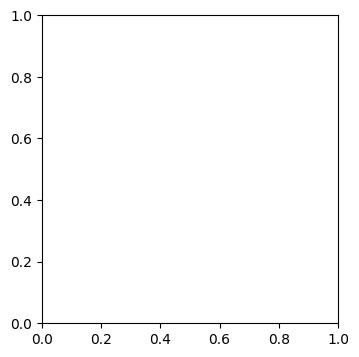

In [20]:
_vmax = 4000
plt.figure(figsize=(13, 4))
plt.subplot(131)
plt.imshow(pc1.sum(axis=0), vmax=_vmax)
plt.title("before")
plt.subplot(132)
plt.imshow(pc2.sum(axis=0), vmax=_vmax)
plt.title("after")
plt.subplot(133)
plt.imshow(pc2.sum(axis=0)-pc1.sum(axis=0), cmap="RdBu_r")
plt.title("difference")
plt.colorbar()

plt.figure(figsize=(7, 7))
plt.scatter(*np.array(cc1).T, color='blue')
plt.scatter(*np.array(cc2).T, color='red')

plt.show()


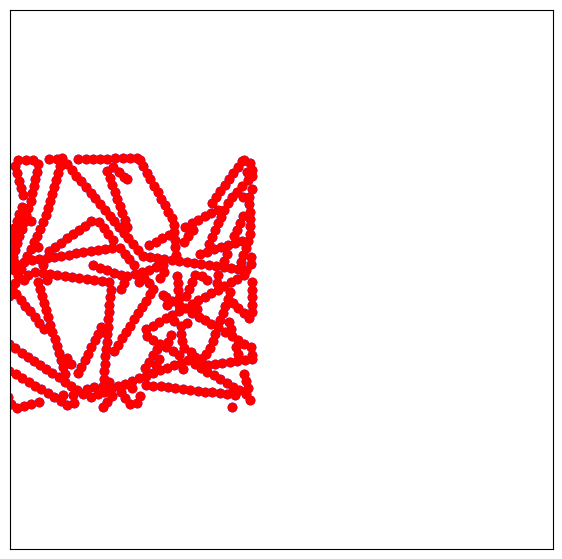

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(*np.array(cc1).T, color='blue')
ax.scatter(*np.array(cc2).T, color='red')
ax.set_ylim(-360, 660)
ax.set_xlim(-360, 660)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

In [20]:
pc1[0].mean()

14.076069672106925

NameError: name 'pc1' is not defined

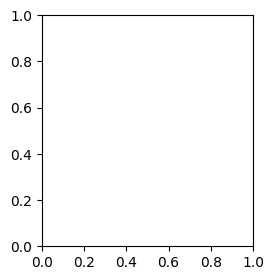

In [22]:
for i in range(0, 160, 2):
    clear_output(wait=True)
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(pc1[i], vmin=30, vmax=50)
    plt.subplot(122)
    plt.imshow(pc2[i], vmin=30, vmax=50)
    plt.title(f"{i=}")
    plt.pause(0.01)
    

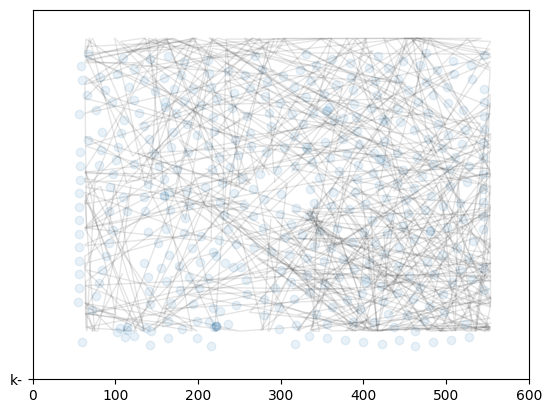

In [59]:
for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T, 'k-', alpha=0.1, lw=1)
plt.scatter(*np.array([300, 300]).reshape(-1, 1) + np.array(brain.get_space_centers()).T, alpha=0.1)
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.show()

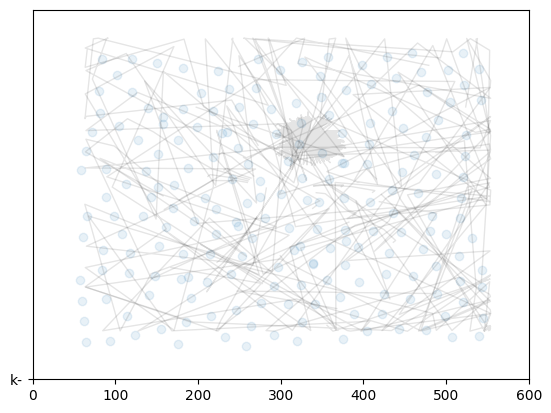

In [140]:
for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T, 'k-', alpha=0.1, lw=1)
plt.scatter(*np.array([300, 300]).reshape(-1, 1) + np.array(brain.get_space_centers()).T, alpha=0.1)
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.show()

In [27]:
len(brain.space)

324

In [31]:
reward_obj.position

[300, 300]

In [143]:
c4 = np.array(cc2) - np.array(cc1)
idxc4 = np.where(c4[:, 0]**2 > 0.001)[0]

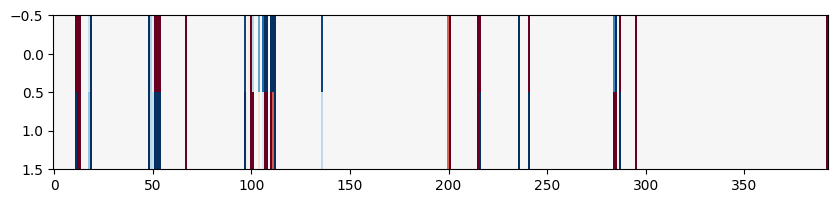

In [56]:
plt.figure(figsize=(10, 2))
plt.imshow(c4.T, cmap="RdBu", vmin=-1, vmax=1, aspect='auto', interpolation='nearest')
plt.show()

In [49]:
brain.get_da_weights().sum()

0.9993419

NameError: name 'idx_diff' is not defined

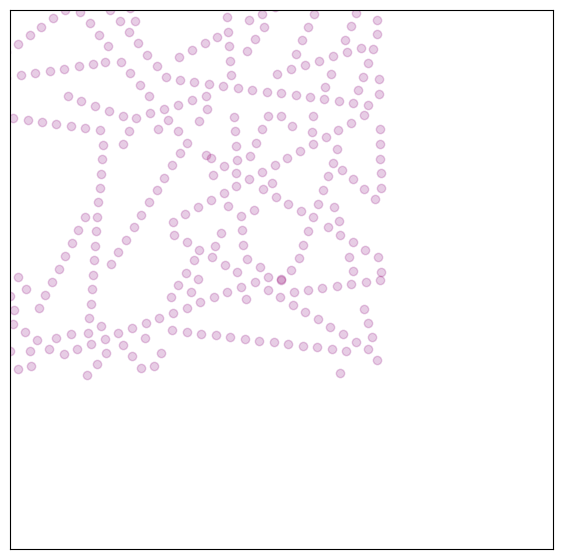

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(*np.array(cc1).T, color='blue', alpha=0.1)
ax.scatter(*np.array(cc2).T, color='red', alpha=0.1)
ax.set_ylim(-260, 260)
ax.set_xlim(-260, 260)
ax.set_xticks(())
ax.set_yticks(())

ax.scatter(*np.array(cc2)[idx_diff].T, alpha=0.5, color='orange')
ax.scatter(*np.array(cc2).T, c=brain.get_da_weights(), alpha=0.5, cmap='Greens')

plt.show()

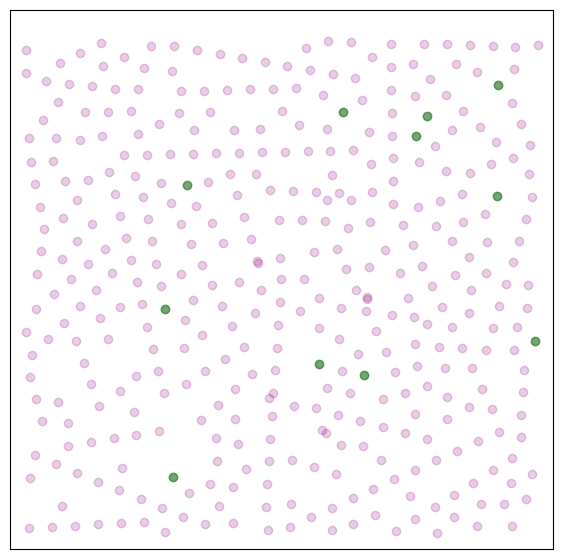

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(*np.array(cc1).T, color='blue', alpha=0.1)
ax.scatter(*np.array(cc2).T, color='red', alpha=0.1)
ax.set_ylim(-260, 260)
ax.set_xlim(-260, 260)
ax.set_xticks(())
ax.set_yticks(())

ax.scatter(*np.array(cc1)[idx_diff].T, alpha=0.5, color='green')

plt.show()

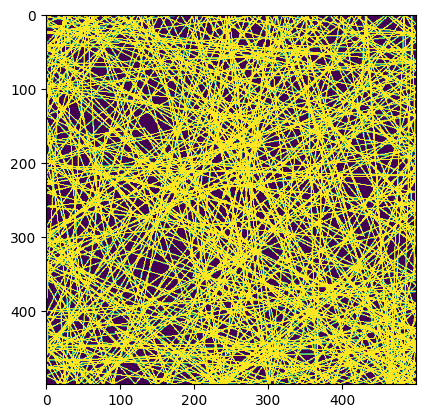

In [87]:
plt.imshow(pc1[0], vmin=0, vmax=15)
plt.show()

In [88]:
gcn = brain.get_gc_network()

In [9]:
space = brain.space

# random walk
speed = 0.9
size = 500.
lims = (-200, 600)

points = [[100., 100.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((784, tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= lims[0] or x >= lims[1]:
        s[0] *= -1
        x += s[0]
    elif y <= lims[0] or y >= lims[1]:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 1000 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t], _ = space([points[-1][0]-old_point[0],
                            points[-1][1]-old_point[1]])
    
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        plt.title(f"{t=}")
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger("[trajectory done]")


  0%|                                                       | 0/100000 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (361,) into shape (784,)

In [140]:
tr = np.array(points).T[:, 1:]
tr.shape

(2, 100000)

In [141]:
activity.sum()

3578.6075919205323

In [137]:
np.where(activity.sum(axis=1)>0)[0]

array([], dtype=int64)

In [163]:
for idx in tqdm(np.where(activity.sum(axis=1)>0)[0]):
    plt.scatter(*tr, c=activity[idx], s=np.where(activity[idx]>0.001, 4, 0))
plt.show()

NameError: name 'activity' is not defined

100%|████████████████████████████████████████████| 37/37 [00:00<00:00, 126.06it/s]


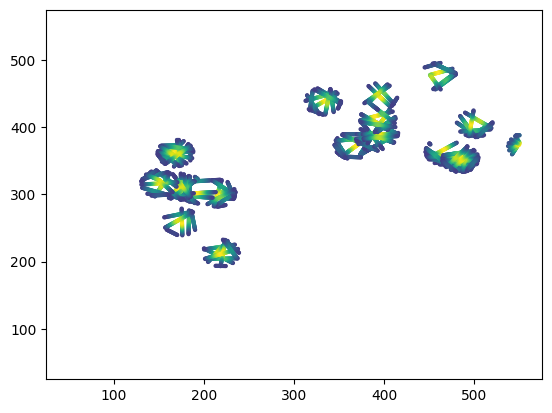

In [144]:
for idx in tqdm(idxc4):
    plt.scatter(*tr, c=activity[idx], s=np.where(activity[idx]>0.001, 4, 0))
plt.show()

In [29]:

zxa1 = d1[np.where(d1.sum(axis=1)>0)[0]]
zxb1 = zxa1 * e1[0, 1:]
zxc1 = zxb1.sum() / zxa1.sum()

zya1 = d1[np.where(d1.sum(axis=1)>0)[0]]
zyb1 = zya1 * e1[1, 1:]
zyc1 = zyb1.sum() / zya1.sum()

zxa2 = d2[np.where(d2.sum(axis=1)>0)[0]]
zxb2 = zxa2 * e1[0, 1:]
zxc2 = zxb2.sum() / zxa2.sum()

zya2 = d2[np.where(d2.sum(axis=1)>0)[0]]
zyb2 = zya2 * e2[1, 1:]
zyc2 = zyb2.sum() / zya2.sum()
logger()

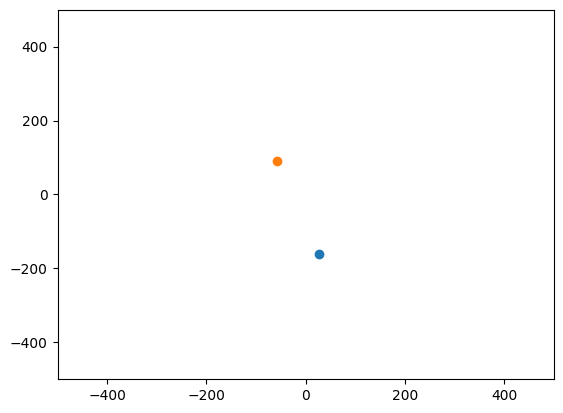

In [30]:

plt.scatter(zxc1, zyc1)
plt.scatter(zxc2, zyc2)
plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:04<00:00, 111.28it/s]


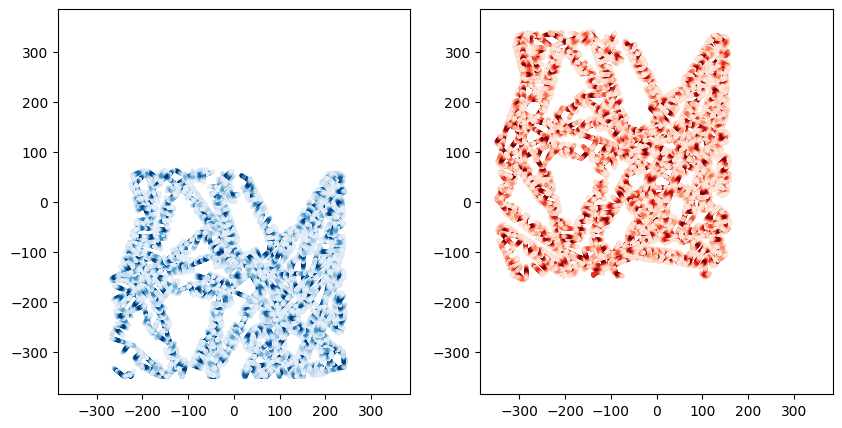

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
for idx in tqdm(np.where(d1.sum(axis=1)>0)[0]):
    plt.scatter(*(e1[:, 1:]), c=d1[idx], s=np.where(d1[idx]>0.001, 4, 0), cmap="Blues")
    
plt.subplot(122)
for idx in tqdm(np.where(d2.sum(axis=1)>0)[0]):
    plt.scatter(*(e2[:, 1:]), c=d2[idx], s=np.where(d2[idx]>0.001, 4, 0), cmap="Reds")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:05<00:00, 96.52it/s]


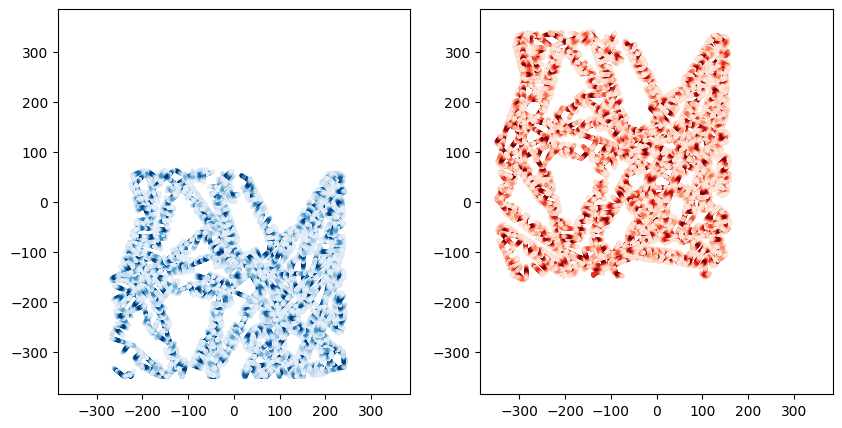

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
for idx in tqdm(np.where(d1.sum(axis=1)>0)[0]):
    plt.scatter(*(e1[:, 1:]), c=d1[idx], s=np.where(d1[idx]>0.001, 4, 0), cmap="Blues")
    
plt.subplot(122)
for idx in tqdm(np.where(d2.sum(axis=1)>0)[0]):
    plt.scatter(*(e2[:, 1:]), c=d2[idx], s=np.where(d2[idx]>0.001, 4, 0), cmap="Reds")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 429/429 [00:05<00:00, 77.69it/s]


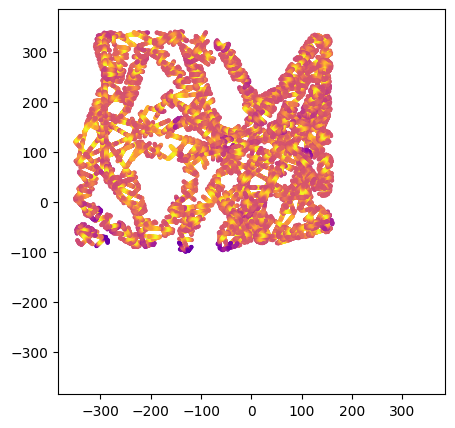

In [37]:
plt.figure(figsize=(5, 5))
d12 = d2-d1
for idx in tqdm(np.where(d1.sum(axis=1)>0)[0]):
    plt.scatter(*(e2[:, 1:]), c=d12[idx], s=np.where(d12[idx]>0.001, 4, 0), cmap="plasma")
plt.show()

100%|█████████████████████████████████████████████████| 91/91 [00:00<00:00, 119.56it/s]


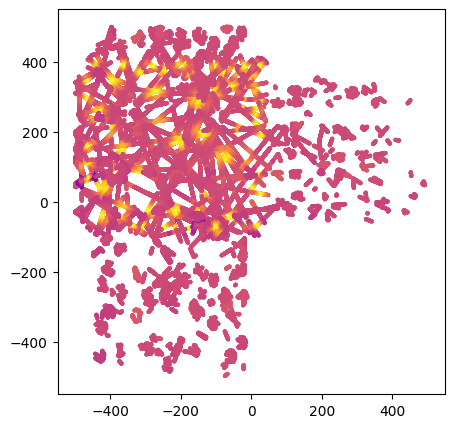

In [20]:
plt.figure(figsize=(5, 5))
d12 = d2-d1
for idx in tqdm(np.where(d1.sum(axis=1)>0)[0]):
    plt.scatter(*(e2[:, 1:]), c=d12[idx], s=np.where(d12[idx]>0.001, 4, 0), cmap="plasma")
plt.show()

In [28]:
tr = np.array(record['trajectory'])
tr.shape

(59999, 2)

In [54]:
tr[t_break]

array([445.67071576, 392.54694153])

In [23]:
env.trajectory_set[1]

[[308.0, 308.0], [308.0, 308.0], [308.0, 308.0], [308.0, 308.0]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:04<00:00, 109.95it/s]


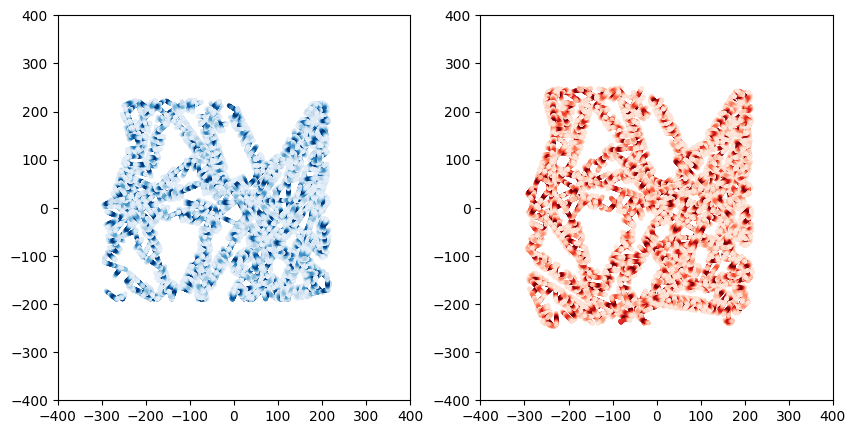

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
for idx in tqdm(np.where(d1.sum(axis=1)>0)[0]):
    plt.scatter(*(e1[:, 1:])-np.array([zxc1, zyc1]).reshape(-1, 1), c=d1[idx], s=np.where(d1[idx]>0.001, 4, 0), cmap="Blues")
plt.xlim(-400, 400)
plt.ylim(-400, 400)

plt.subplot(122)
for idx in tqdm(np.where(d2.sum(axis=1)>0)[0]):
    plt.scatter(*(e2[:, 1:])-np.array([zxc2, zyc2]).reshape(-1, 1), c=d2[idx], s=np.where(d2[idx]>0.001, 4, 0), cmap="Reds")
plt.xlim(-400, 400)
plt.ylim(-400, 400)

plt.show()

---

In [32]:
cc_diff = np.array(cc2) - np.array(cc1)
idx_diff = np.where(cc_diff[:, 0]**2 > 0.001)[0]
e1.shape, d1.shape, idx_diff

((2, 200001), (1024, 200000), array([], dtype=int64))

In [36]:
for idx in tqdm(idx_diff):
    plt.scatter(*(e1[:, 1:]), c=d1[idx], s=np.where(d1[idx]>0.001, 4, 0))
plt.show()

0it [00:00, ?it/s]


100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 99.94it/s]


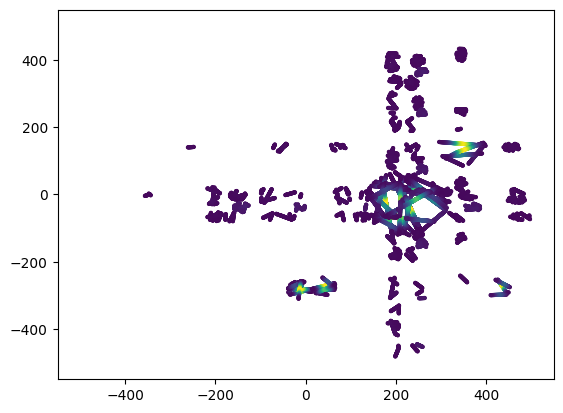

In [20]:
for idx in tqdm(idx_diff):
    plt.scatter(*(e2[:, 1:]), c=d2[idx], s=np.where(d2[idx]>0.001, 4, 0))
plt.show()

In [35]:
for idx in range(len(idx_diff)):
    print(idx)
    clear_output(wait=True)
    plt.scatter(*(e1[:, 1:]), c=d1[idx_diff[idx]], s=np.where(d1[idx_diff[idx]]>0.001, 4, 0), cmap='Blues', alpha=0.5)
    plt.scatter(*(e2[:, 1:]), c=d2[idx_diff[idx]], s=np.where(d2[idx_diff[idx]]>0.001, 4, 0), cmap='Reds', alpha=0.5)
    plt.title(f"{idx=}")
    plt.pause(0.01)

plt.show()

In [154]:
env.trajectory_set[env.set_time_flag:]

array([[0, 0]])

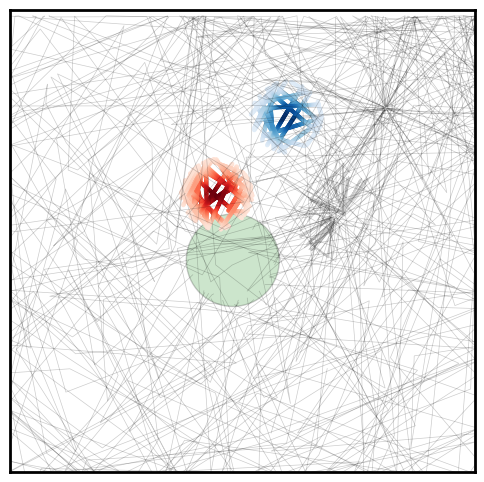

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Create axis with thicker borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Thicker border lines
    
for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T-np.array([300, 300]).reshape(-1, 1), 'k-', alpha=0.2, lw=0.5)

circle = Circle([reward_obj.position[0]-300, reward_obj.position[1]-300], reward_obj.radius,
                edgecolor='black', facecolor='green', alpha=0.2)

ax.add_patch(circle)
idxarr = np.arange(4, 5)
ax.scatter(*(e1[:, 1:]), c=d1[idx_diff[idxarr]].sum(axis=0),
           s=np.where(d1[idx_diff[idxarr]]>0.05, 4, 0).sum(axis=0), cmap='Blues', alpha=0.9)

ax.scatter(*(e2[:, 1:]), c=d2[idx_diff[idxarr]].sum(axis=0),
           s=np.where(d2[idx_diff[idxarr]]>0.05, 4, 0).sum(axis=0), cmap='Reds', alpha=0.9)
ax.set_xlim(-230, 250)
ax.set_ylim(-220, 260)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

#### connectivity density

In [135]:
wrec = brain.get_space_wrec()
degrees = wrec.sum(axis=1)

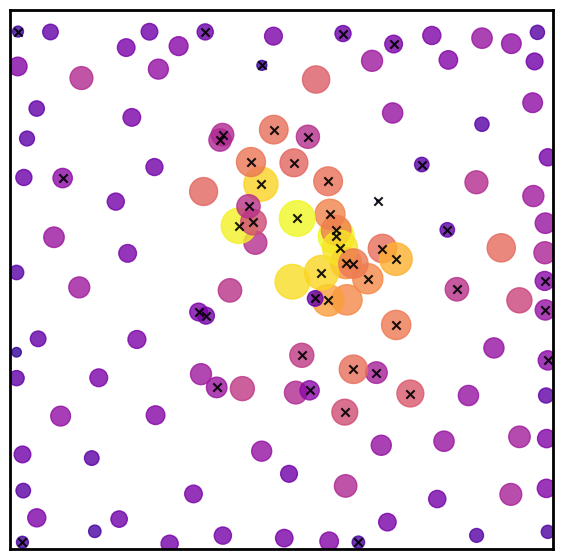

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Create axis with thicker borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Thicker border lines
    
ax.scatter(*np.array(cc2).T, c=np.maximum(degrees, 2), s=np.maximum(degrees, 2), cmap="plasma", alpha=0.8)

ax.set_xlim(-400, 100)
ax.set_ylim(-100, 400)
ax.set_xticks(())
ax.set_yticks(())

ax.scatter(*np.array(cc2)[idx_diff].T, alpha=0.9, color='black', marker='x')

plt.show()

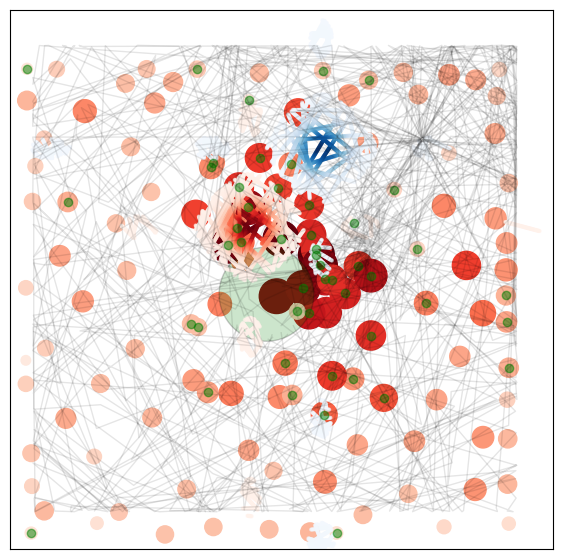

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(*np.array(cc2).T + np.array([150, -150]).reshape(-1, 1), c=degrees, s=degrees, cmap="Reds")

for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T-np.array([300, 300]).reshape(-1, 1), 'k-', alpha=0.1, lw=1)

circle = Circle([reward_obj.position[0]-300, reward_obj.position[1]-300], reward_obj.radius,
                edgecolor='black', facecolor='green', alpha=0.2)

ax.add_patch(circle)
idxarr = np.arange(4, 5)
ax.scatter(*(e1[:, 1:]), c=d1[idx_diff[idxarr]].sum(axis=0),
           s=np.where(d1[idx_diff[idxarr]]>0.0, 4, 0).sum(axis=0), cmap='Blues', alpha=0.5)

ax.scatter(*(e2[:, 1:]), c=d2[idx_diff[idxarr]].sum(axis=0),
           s=np.where(d2[idx_diff[idxarr]]>0.0, 4, 0).sum(axis=0), cmap='Reds', alpha=0.5)
ax.set_xlim(-260, 290)
ax.set_ylim(-260, 290)


ax.set_xticks(())
ax.set_yticks(())

#ax.scatter(*np.array(cc1)[idx_diff].T, alpha=0.5, color='green')
ax.scatter(*np.array(cc2)[idx_diff].T + np.array([150, -150]).reshape(-1, 1),
           alpha=0.5, color='green')

plt.show()